## <u> Smoking Health Data </u>
**Data filtered from a Hypertension Risk Dataset by Md Raihan Kahn. Analyzing the effect of smoking on different health inicators and using a logistic regression model to predict if a person smokes based on those features**


<hr style="border:2px solid black"> </hr>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from scipy.stats import ttest_ind

sns.set_style("whitegrid") #styling the plots

# Load smoking health data into a DataFrame
smoke_data = pd.read_csv("/content/gdrive/MyDrive/DS/smoking_health_data_final.csv")

smoke_df = smoke_data.copy()

# Handling missing values
# Check for missing values
missing_values = smoke_df.isnull().sum()
print("Missing values per column:\n", missing_values)

# replace missing values with the median of their respective columns to overcome outliers effect
for feature in ['heart_rate', 'cigs_per_day', 'chol']:
    median_value = smoke_df[feature].median()
    smoke_df[feature].fillna(median_value, inplace=True)

# Split blood pressure to systolic and diastolic columns
smoke_df['systolic_pressure'] = smoke_df['blood_pressure'].apply(lambda x: int(float(x.split('/')[0])))
smoke_df['diastolic_pressure'] = smoke_df['blood_pressure'].apply(lambda x: int(float(x.split('/')[1])))
smoke_df.drop(columns=['blood_pressure'], inplace=True)

# Summarize key statistics for each variable
stats_summary = smoke_df.describe().T
stats_summary['range'] = stats_summary['max'] - stats_summary['min']
print("\nSummary Statistics:\n", stats_summary)

smoke_df.head()


Missing values per column:
 age                0
sex                0
current_smoker     0
heart_rate         0
blood_pressure     0
cigs_per_day      14
chol               7
dtype: int64

Summary Statistics:
                      count        mean        std    min    25%    50%    75%  \
age                 3900.0   49.537949   8.559275   32.0   42.0   49.0   56.0   
heart_rate          3900.0   75.688974  12.015376   44.0   68.0   75.0   82.0   
cigs_per_day        3900.0    9.135641  12.028875    0.0    0.0    0.0   20.0   
chol                3900.0  236.591282  44.335649  113.0  206.0  234.0  263.0   
systolic_pressure   3900.0  132.300000  21.979268   83.0  117.0  128.0  144.0   
diastolic_pressure  3900.0   82.908462  11.924275   48.0   75.0   82.0   90.0   

                      max  range  
age                  70.0   38.0  
heart_rate          143.0   99.0  
cigs_per_day         70.0   70.0  
chol                696.0  583.0  
systolic_pressure   295.0  212.0  
diastolic_pr

,age,sex,current_smoker,heart_rate,cigs_per_day,chol,systolic_pressure,diastolic_pressure
0,54,male,yes,95,0.0,219.0,110,72
1,45,male,yes,64,0.0,248.0,121,72
2,58,male,yes,81,0.0,235.0,127,76
3,42,male,yes,90,0.0,225.0,122,80
4,42,male,yes,62,0.0,226.0,119,80


Smoking Distribution across Age Groups and Genders:
 current_smoker     no  yes
age_group sex             
30-40     female  162  195
          male    111  222
40-50     female  395  389
          male    231  476
50-60     female  451  188
          male    244  303
60-70     female  246   55
          male    128  104

Percentage of Smokers within each Age Group and Gender Category:
 current_smoker           no        yes
age_group sex                         
30-40     female  45.378151  54.621849
          male    33.333333  66.666667
40-50     female  50.382653  49.617347
          male    32.673267  67.326733
50-60     female  70.579030  29.420970
          male    44.606947  55.393053
60-70     female  81.727575  18.272425
          male    55.172414  44.827586


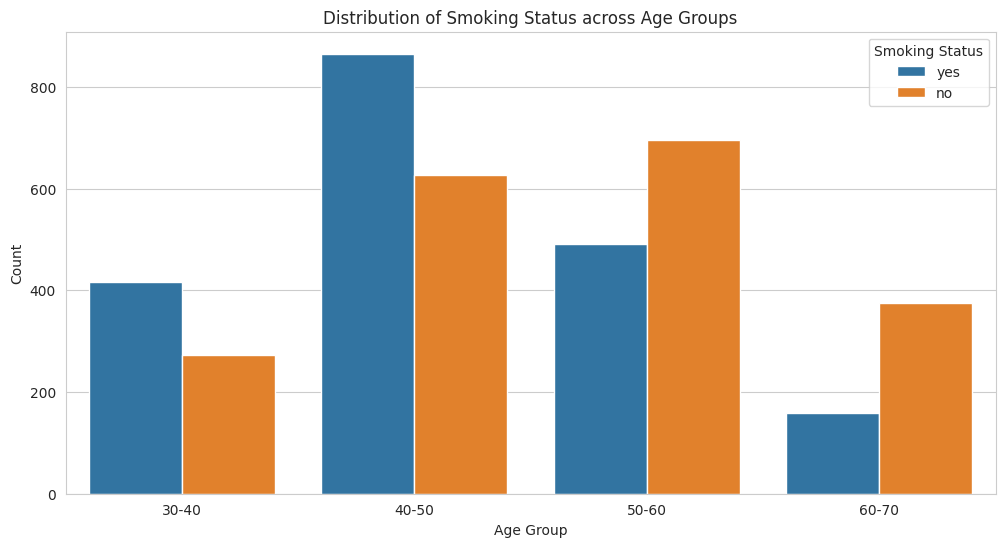

<Figure size 1200x600 with 0 Axes>

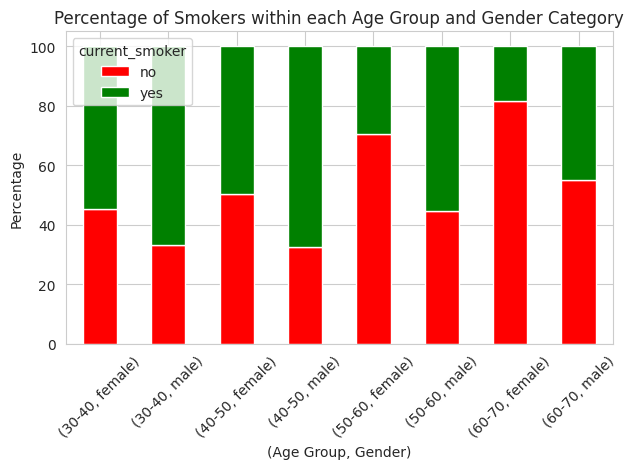

In [100]:
# Creating age groups
smoke_df['age_group'] = pd.cut(smoke_df['age'], bins=[30, 40, 50, 60, 70], labels=['30-40', '40-50', '50-60', '60-70'])

# the distribution of smoking across different age groups and genders
ageGroup_genders_distribution = pd.crosstab(index=[smoke_df['age_group'], smoke_df['sex']], columns=smoke_df['current_smoker'])
print("Smoking Distribution across Age Groups and Genders:\n", ageGroup_genders_distribution)

# Calculate the percentage of smokers within each age group and gender category
smoking_status_percentage = ageGroup_genders_distribution.div(ageGroup_genders_distribution.sum(axis=1), axis=0) * 100
print("\nPercentage of Smokers within each Age Group and Gender Category:\n", smoking_status_percentage)


# Distribution of smoking status across different age groups and genders - Visualization
plt.figure(figsize=(12, 6))
sns.countplot(x='age_group', hue='current_smoker', data=smoke_df)
plt.title('Distribution of Smoking Status across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Smoking Status')

# Percentage of smokers within each age group and gender category - Visualization
plt.figure(figsize=(12, 6))
smoking_status_percentage.plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title('Percentage of Smokers within each Age Group and Gender Category')
plt.xlabel('(Age Group, Gender)')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

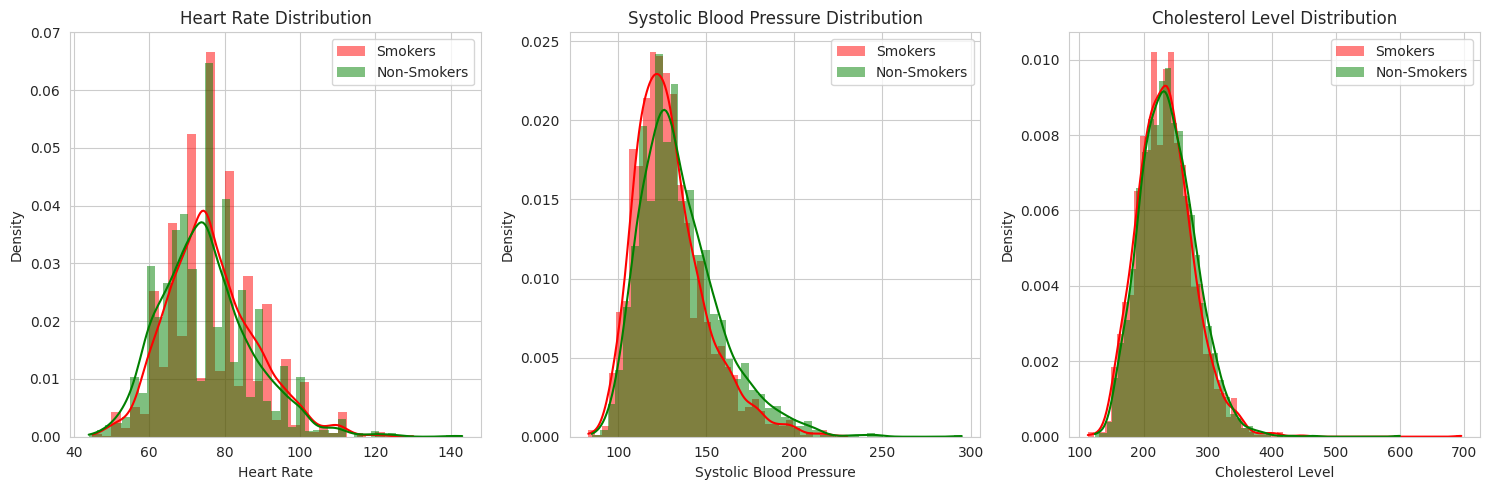

In [106]:
# Select only the relevant health indicators
health_indicators = smoke_df[['current_smoker', 'heart_rate', 'systolic_pressure', 'diastolic_pressure', 'chol']]

# Split the data into smokers and non-smokers
smokers = health_indicators[health_indicators['current_smoker'] == 'yes']
non_smokers = health_indicators[health_indicators['current_smoker'] == 'no']

# Visualize the distributions of health indicators for smokers and non-smokers
plt.figure(figsize=(15, 5))

# Heart Rate
plt.subplot(1, 3, 1)
sns.histplot(smokers['heart_rate'], color='red', label='Smokers', kde=True, stat="density", linewidth=0)
sns.histplot(non_smokers['heart_rate'], color='green', label='Non-Smokers', kde=True, stat="density", linewidth=0)
plt.xlabel('Heart Rate')
plt.title('Heart Rate Distribution')
plt.legend()

# Blood Pressure (Systolic)
plt.subplot(1, 3, 2)
sns.histplot(smokers['systolic_pressure'], color='red', label='Smokers', kde=True, stat="density", linewidth=0)
sns.histplot(non_smokers['systolic_pressure'], color='green', label='Non-Smokers', kde=True, stat="density", linewidth=0)
plt.xlabel('Systolic Blood Pressure')
plt.title('Systolic Blood Pressure Distribution')
plt.legend()

# Cholesterol Levels
plt.subplot(1, 3, 3)
sns.histplot(smokers['chol'], color='red', label='Smokers', kde=True, stat="density", linewidth=0)
sns.histplot(non_smokers['chol'], color='green', label='Non-Smokers', kde=True, stat="density", linewidth=0)
plt.xlabel('Cholesterol Level')
plt.title('Cholesterol Level Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [107]:
# Perform t-tests to know the differences in means between smokers and non-smokers
t_test_heart_rate = ttest_ind(smokers['heart_rate'], non_smokers['heart_rate'])
t_test_systolic_bp = ttest_ind(smokers['systolic_pressure'], non_smokers['systolic_pressure'])
t_test_chol = ttest_ind(smokers['chol'], non_smokers['chol'])

print("T-test results for Heart Rate:", t_test_heart_rate)
print("T-test results for Systolic Blood Pressure:", t_test_systolic_bp)
print("T-test results for Cholesterol Levels:", t_test_chol)

T-test results for Heart Rate: TtestResult(statistic=3.579584820675851, pvalue=0.00034833312553790417, df=3898.0)
T-test results for Systolic Blood Pressure: TtestResult(statistic=-8.528244094077328, pvalue=2.096520089645185e-17, df=3898.0)
T-test results for Cholesterol Levels: TtestResult(statistic=-2.9135033435100053, pvalue=0.0035943048293932767, df=3898.0)


In [115]:
# Group data by age group and smoking status, ensuring the 'observed' parameter is set correctly to avoid FutureWarnings
grouped = smoke_df.groupby(['age_group', 'current_smoker'], observed=True)

# Calculate mean values for health indicators within each group
mean_health_data = grouped[['heart_rate', 'systolic_pressure', 'diastolic_pressure', 'chol']].mean()

# Display the mean health data for comparison
print("Mean Health Indicators by Age Group and Smoking Status:\n", mean_health_data)



Mean Health Indicators by Age Group and Smoking Status:
                           heart_rate  systolic_pressure  diastolic_pressure  \
age_group current_smoker                                                      
30-40     no               75.179487         121.736264           79.402930   
          yes              75.693046         120.760192           77.954436   
40-50     no               75.263578         129.669329           83.781150   
          yes              76.776879         126.897110           81.334104   
50-60     no               74.631655         138.828777           85.566906   
          yes              76.641548         136.391039           84.219959   
60-70     no               75.152406         147.788770           86.002674   
          yes              75.251572         142.849057           84.100629   

                                chol  
age_group current_smoker              
30-40     no              209.827839  
          yes             219.81774

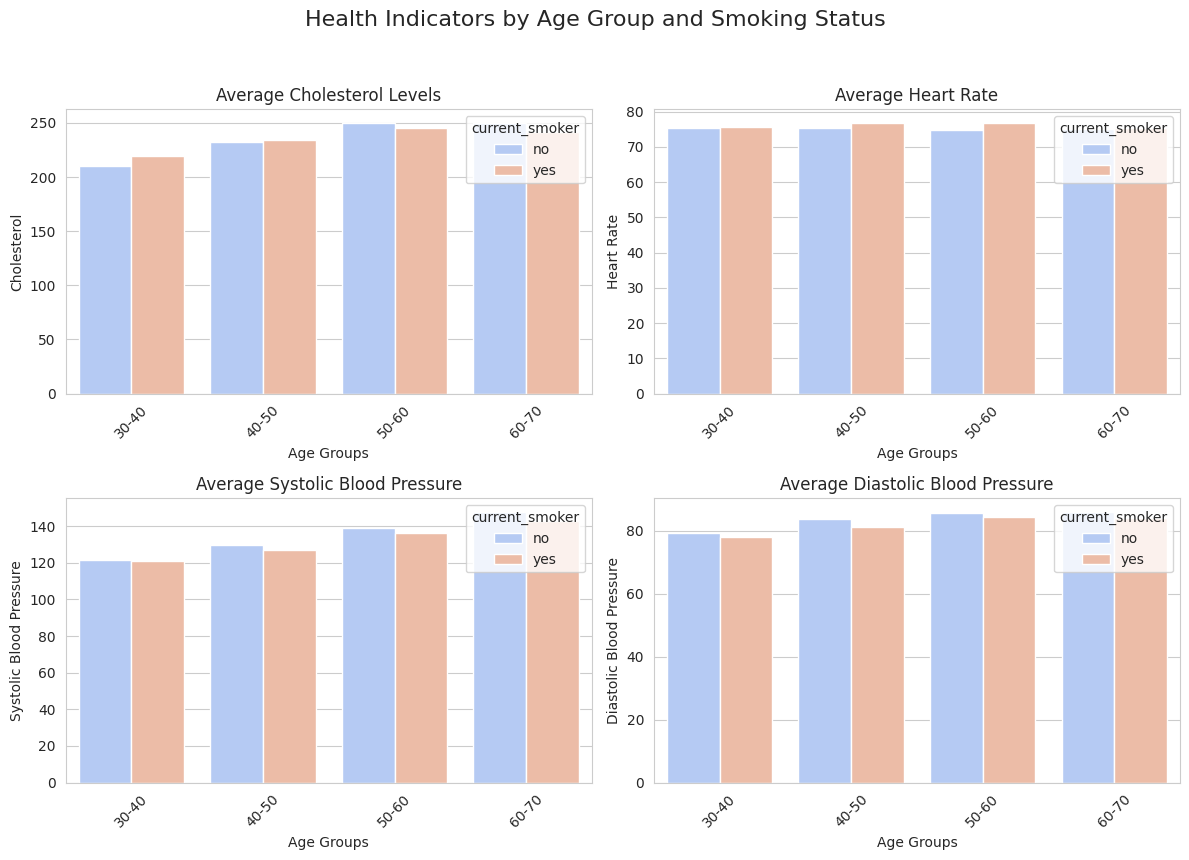

In [129]:
# Visualizing the data
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.suptitle('Health Indicators by Age Group and Smoking Status', fontsize=16)


# Cholesterol Levels
# Reset the index of the DataFrame
mean_health_data_reset = mean_health_data.reset_index()

# Now use 'mean_health_data_reset' in your plots
sns.barplot(ax=axes[0, 0], x=mean_health_data_reset['age_group'], y=mean_health_data_reset['chol'], hue=mean_health_data_reset['current_smoker'], palette='coolwarm')
axes[0, 0].set_title('Average Cholesterol Levels')
axes[0, 0].set_xlabel('Age Groups')
axes[0, 0].set_ylabel('Cholesterol')
axes[0, 0].tick_params(axis='x', rotation=45)

# Heart Rate
mean_health_data_reset = mean_health_data.reset_index()

sns.barplot(ax=axes[0, 1], x=mean_health_data_reset['age_group'], y=mean_health_data_reset['heart_rate'], hue=mean_health_data_reset['current_smoker'], palette='coolwarm')
axes[0, 1].set_title('Average Heart Rate')
axes[0, 1].set_xlabel('Age Groups')
axes[0, 1].set_ylabel('Heart Rate')
axes[0, 1].tick_params(axis='x', rotation=45)

# Systolic Blood Pressure
mean_health_data_reset = mean_health_data.reset_index()

# Now use 'mean_health_data_reset' in your plots
sns.barplot(ax=axes[1, 0], x=mean_health_data_reset['age_group'], y=mean_health_data_reset['systolic_pressure'], hue=mean_health_data_reset['current_smoker'], palette='coolwarm')
axes[1, 0].set_title('Average Systolic Blood Pressure')
axes[1, 0].set_xlabel('Age Groups')
axes[1, 0].set_ylabel('Systolic Blood Pressure')
axes[1, 0].tick_params(axis='x', rotation=45)

# Diastolic Blood Pressure
# Reset the index of the DataFrame
mean_health_data_reset = mean_health_data.reset_index()

# Now use 'mean_health_data_reset' in your plots
mean_health_data_reset = mean_health_data.reset_index()
sns.barplot(ax=axes[1, 1], x=mean_health_data_reset['age_group'], y=mean_health_data_reset['diastolic_pressure'], hue=mean_health_data_reset['current_smoker'], palette='coolwarm')
axes[1, 1].set_title('Average Diastolic Blood Pressure')
axes[1, 1].set_xlabel('Age Groups')
axes[1, 1].set_ylabel('Diastolic Blood Pressure')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [130]:
# T-tests within each age group to compare smokers and non-smokers
for age_group in smoke_df['age_group'].unique():
    smokers_group = smoke_df[(smoke_df['age_group'] == age_group) & (smoke_df['current_smoker'] == 'yes')]
    non_smokers_group = smoke_df[(smoke_df['age_group'] == age_group) & (smoke_df['current_smoker'] == 'no')]
    print(f"\nT-test results for {age_group}:")
    for test_var in ['heart_rate', 'systolic_pressure', 'diastolic_pressure', 'chol']:
        t_stat, p_val = ttest_ind(smokers_group[test_var].dropna(), non_smokers_group[test_var].dropna())
        print(f"{test_var.capitalize()}: statistic={t_stat:.4f}, p-value={p_val:.4f}")


T-test results for 50-60:
Heart_rate: statistic=2.8541, p-value=0.0044
Systolic_pressure: statistic=-1.8676, p-value=0.0621
Diastolic_pressure: statistic=-1.9054, p-value=0.0570
Chol: statistic=-1.6343, p-value=0.1025

T-test results for 40-50:
Heart_rate: statistic=2.4500, p-value=0.0144
Systolic_pressure: statistic=-2.8959, p-value=0.0038
Diastolic_pressure: statistic=-4.1172, p-value=0.0000
Chol: statistic=0.8724, p-value=0.3831

T-test results for 30-40:
Heart_rate: statistic=0.5448, p-value=0.5861
Systolic_pressure: statistic=-0.8549, p-value=0.3929
Diastolic_pressure: statistic=-1.8125, p-value=0.0703
Chol: statistic=3.1432, p-value=0.0017

T-test results for 60-70:
Heart_rate: statistic=0.0832, p-value=0.9337
Systolic_pressure: statistic=-1.9040, p-value=0.0575
Diastolic_pressure: statistic=-1.5032, p-value=0.1334
Chol: statistic=-1.9240, p-value=0.0549


In [140]:
from sklearn.model_selection import train_test_split

X = smoke_df.drop(columns=['current_smoker'])  # Features
y = smoke_df['current_smoker']  # Target variable

smoke_df_encoded =pd.get_dummies(X).astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(smoke_df_encoded, y, test_size=0.2, random_state=365)


In [146]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
model = LogisticRegression(max_iter=3000)


# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9961538461538462


In [147]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a new model with the best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (after hyperparameter tuning):", accuracy)

Best Hyperparameters: {'C': 10}
Accuracy (after hyperparameter tuning): 0.9961538461538462
